# Noisy DQN

For ReLAx & Mujoco installation see: https://github.com/nslyubaykin/relax/blob/master/README.md

Useful readings regarding Noisy DQN:

- DQN paper: https://arxiv.org/pdf/1312.5602.pdf
- Noisy DQN paper: https://arxiv.org/pdf/1706.10295.pdf

!Note: For examining trained actor you may just load trained policies from \trained_models directory. To do that instead of running 'Run Training and Validation loop' cell, just run 'Load Models' cell

!Note: Trained policies, logs and videos are in the main repository of that notebook: https://github.com/nslyubaykin/relax_noisy_dqn_example

In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from inspect import getsource
from torch.utils.tensorboard import SummaryWriter

from relax.rl.critics import DQN
from relax.rl.actors import ArgmaxQValue

from relax.zoo.critics import AtariNoisyQCNN

from relax.schedules import PiecewiseSchedule

from relax.gym.utils import get_wrapper_by_name, visualize_actor
from relax.gym.wrappers.atari import *

from relax.data.sampling import Sampler
from relax.data.replay_buffer import ReplayBuffer

/home/nikita/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constructing Discrete Deep Q-Network Critic

DQN is a discrete action RL algorithm. That means that critic net is taking as an input an observations batch with a shape of (BATCH_SIZE, \*obs.shape) (for Atari domain observation is a batch of stacked frames which then processed by CNN feature extractor) and outputting a batch of Q-Values for each discrete action with a shape (BATCH_SIZE, ACS_DIM).

# Noisy Layers

NoisyNets are neural networks whose weights and biases are perturbed by a parametric function of the noise. These parameters are adapted with gradient descent. To implement NoisyNets use `relax.zoo.layers.NoisyLinear` instead of `torch.nn.Linear`.

Therefore any custom user defined networks meeting this requirements should work well with DQN critic

So let's examine the default implementation of Noisy Atari Discrete Deep Q-Network Critic offered by ReLAx:

In [2]:
print(getsource(AtariNoisyQCNN))

class AtariNoisyQCNN(nn.Module):
    
    def __init__(self, in_channels, acs_dim, std_init=0.5):
        
        super(AtariNoisyQCNN, self).__init__()
        
        self.net = nn.Sequential(
            PreprocessImg(),
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            NoisyLinear(3136, 512, std_init=std_init),  # 3136 hard-coded based on img size + CNN layers
            nn.ReLU(),
            NoisyLinear(512, acs_dim, std_init=std_init),
        )
        
    def forward(self, x):
        
        logits = self.net(x)
        
        return logits



# Constructing ArgmaxQValue actor

DQN uses a greedy non-parametric actor which simply selects an action with the biggest Q-value estimated by DQN critc

# Define Schedules for Training:

Our DQN actor will not learn for the first 50k iterations. (Told to actor by passing 0 learning rate for the first 50k iterations)

And it will also conduct maximum exploration during that phase to collect initial random training data.

*!Note: we will construct our exploration schedule to be 30m timestamps long, however, for the time-saving purpose, we will run demonstration training only for 3m steps. In papers, DQN and its augmentations are trained for 200m steps, which may require several days of learning.*

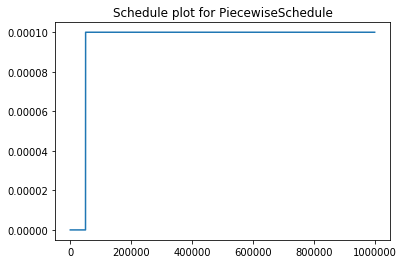

In [3]:
lr_schedule = PiecewiseSchedule({0: 50000}, 1e-4)
lr_schedule.plot(int(1e6))

# Create training and eval environments

On practice, when training DQN on Atari 2600 domain, algorithm is not fed with raw environment observations, instead several wrappers are applied:

1) EpisodicLifeEnv - make end-of-life == end-of-episode, but only reset on true game over. Done by DeepMind for the DQN and co. since it helps value estimation

2) NoopResetEnv - Sample initial states by taking random number of no-ops on reset. No-op is assumed to be action 0.

3) MaxAndSkipEnv - Return only every skip-th frame and do max-pooling over most recent two observations

4) FireResetEnv - Take action on reset for environments that are fixed until firing.

5) ProcessFrame84 - Crop valid region of an observation, convert to grayscale, resize to 84x84. Cast to uint8 dtype for lower memory usage.

6) ClipRewardEnv - Bin reward to {+1, 0, -1} by its sign.

In [4]:
def makeenv(env_name, hcrop, hstretch, seed):
    
    env = gym.make(env_name)
    ob_unwrap = env.reset()
    
    env = gym.wrappers.Monitor(
        env,
        'monitor_train_logs',
        force=True,
        video_callable=None,
    )
    
    env = wrap_deepmind(
        env, 
        skip=4,
        hcrop=hcrop, 
        hstretch=hstretch
    )
    
    env.seed(seed)
    
    ob = env.reset()
    
    return env, ob_unwrap, ob 

In [5]:
env_name = 'Asteroids-v0'

# Capture game region by adjusting these params:
hcrop=18 # skip n top lines of pixels
hstretch=110 # compression of vertical dimention from 210 -> hstretch (should be > than hcrop+84)

env, ob_unwrap, ob = makeenv(
    env_name=env_name, hcrop=hcrop, 
    hstretch=hstretch, seed=12
)

eval_env, _, _ = makeenv(
    env_name=env_name, hcrop=hcrop, 
    hstretch=hstretch, seed=27
)


print(ob_unwrap.shape, ob.shape)

(210, 160, 3) (84, 84, 1)


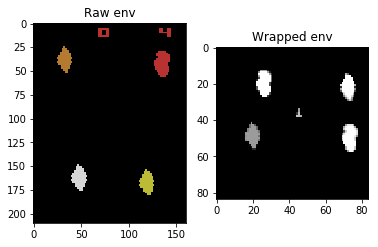

In [6]:
# Visualize raw and wrapped environment:
plt.subplot(1, 2, 1)
plt.imshow(ob_unwrap)
plt.title('Raw env')
plt.subplot(1, 2, 2)
plt.imshow(ob.squeeze(), cmap='gray')
plt.title('Wrapped env')
plt.show()

In [7]:
env.action_space

Discrete(14)

In [8]:
acs_dim = 14

#  Set Up Exploration

As DQN critic network's weights and biases are perturbed by a parametric function of the noise, which is learned during gradient descent, there is no  need for an additional $\epsilon$-greedy exploration. Exploration magnitude will be learned by the model itself.

# Define ArgmaxQValue actor

In [9]:
actor = ArgmaxQValue(
        exploration=None
)

# Define DQN critic:

!Note: Atari 2600 environments often have some blinking visual elements, that is why observation may miss some details due to the blinking period, therefore introducing *partial observability*. To counteract this, critic network receives a stack of a current frame and 3 most recent lags. By doing so, critic, in theory, should be able to reconstruct actual state from frames history.

ReLAx offers a simple interface to use lagged observations by specifying the following args:

`obs_nlags`: int - specify the number of lags in addition to current observation

`obs_expand_axis`: int or None - if not None, creates an extra dimension in observation array to concat along, if needed

`obs_concat_axis`: int - axis to concatenate lags along

`obs_padding`: str - ('zeros', 'first') value to pad starting observations with.

Observation shape of the observations returned by DeepMind environment wrapper is (84, 84, 1) so, by specifying:

`obs_nlags`=3

`obs_expand_axis`=None

`obs_concat_axis`=-1

`obs_padding=`'zeros'

We end up with a stacked lagged observation with a shape (84, 84, 4)

In [10]:
critic = DQN(
    critic_net=AtariNoisyQCNN( # Noisy DQN
        in_channels=4, # 1 current frame + 3 recent lags
        acs_dim=acs_dim
    ),
    device=torch.device('cuda'),
    learning_rate=lr_schedule,
    batch_size=32,
    gamma=0.99,
    target_updates_freq=10000,
    n_steps_per_update=1,
    update_freq=4,
    double_q=False,
    obs_nlags=3,
    obs_expand_axis=None,
    obs_concat_axis=-1,
    obs_padding='zeros'
)

# Provide actor with critic:

In [11]:
actor.set_critic(critic)

# Wrap envs into Sampler:

!Note: As we are using lags as an input to critic (and actor is using critic to select actions), our sampler also should accumulate lags to ensure correct input on a sampling phase. To make Sampler use lags, you should provide it with the same set of args:

`obs_nlags`: int - specify the number of lags in addition to current observation

`obs_expand_axis`: int or None - if not None, creates an extra dimension in observation array to concat along, if needed

`obs_concat_axis`: int - axis to concatenate lags along

`obs_padding`: str - ('zeros', 'first') value to pad starting observations with.

In [12]:
sampler = Sampler(env=env,
                  obs_nlags=3,
                  obs_expand_axis=None,
                  obs_concat_axis=-1,
                  obs_padding='zeros')

eval_sampler = Sampler(env=eval_env,
                       obs_nlags=3,
                       obs_expand_axis=None,
                       obs_concat_axis=-1,
                       obs_padding='zeros')

# Create replay buffer

!Note: ReplayBuffer is designed not to store lags explicitly (and not to store next states also) that is why the number of lags will not affect the amount of RAM used. However, as it still has to store 1m experience history and each observation is an array of shape (84, 84, 1) with a dtype uint8, the total amount of RAM usage by ReplayBuffer $ \approx $ 10^6 \* 84 \* 84 bytes ~= 7 gigabytes. In total, DQN training requires $ \approx $ 9-10 gigabytes of RAM. If your machine does not have enough RAM - consider decreasing buffer size.

In [13]:
replay_buffer = ReplayBuffer(int(1e+6))

# Visualize untrained actor

In [14]:
visualize_actor(env=eval_env, actor=actor, nsteps=1000, train_sampling=False)

Simulation done, total reward: 1.0
Loading video...


# Run Training and Validation loop:

!Note: we have constructed our exploration schedule to be 30m timestamps long, however, for the time-saving purpose, we will run demonstration training only for 3m steps. In papers, DQN and its augmentations are trained for 200m steps, which may require several days of learning.

In [ ]:
log_every = 50000
n_steps = 3000000
logdir = '/home/nikita/Desktop/RelaxExamples/Noisy_DQN/tensorboard_logs'
run_name = f'noisy_dqn_{env_name}_2'
logger = SummaryWriter(log_dir=f'{logdir}/{run_name}')
all_logs = []

for step in tqdm(range(n_steps)): # 
    
    # sample training batch
    unit_pathlist = sampler.sample(actor=actor,
                                   n_transitions=1,
                                   max_path_length=None, 
                                   reset_when_not_done=False,
                                   train_sampling=True)
    
    # add transitions to replay buffer
    replay_buffer.add_paths(unit_pathlist)
    
    # update critic
    critic_logs = critic.update(replay_buffer)
        
    # update actor
    actor_logs = actor.update(replay_buffer)
    
    if step % log_every == 0 and step > 0:
        
        # add unwrapped reward logs
        mean_unwr_train = np.mean(get_wrapper_by_name(env, 'Monitor').get_episode_rewards()[-20:])
        unwr_rews = {'average_train_unwr_rews': mean_unwr_train}
        
        # create logs of buffer
        buffer_logs = replay_buffer.create_logs(prefix='buffer')

        logs = {**critic_logs,
                **actor_logs,
                **buffer_logs,
                **unwr_rews}
        all_logs.append(logs)
        
        for key, value in logs.items():
            logger.add_scalar(key, value, step)
    
logger.flush()

 67%|██████▋   | 2024216/3000000 [5:05:09<21847:05:34, 80.60s/it] 

In [1]:
%load_ext tensorboard
%tensorboard --logdir /home/nikita/Desktop/RelaxExamples/Noisy_DQN/tensorboard_logs

Reusing TensorBoard on port 6006 (pid 48337), started 19:29:08 ago. (Use '!kill 48337' to kill it.)

# Plot learning curve

In [ ]:
eval_score = [l['average_train_unwr_rews'] for l in all_logs]
plt.plot(eval_score)
plt.title(f'Learning curve for {env_name}')
plt.xlabel('Training step')
plt.ylabel('Avg. return')
plt.show()

# Plot estimated vs actual Q-values

In [ ]:
batch = eval_sampler.sample_n_episodes(actor=actor,
                                       n_episodes=10,
                                       max_path_length=None, 
                                       train_sampling=False)

print(*batch.create_logs().items(), sep='\n')

batch.add_disc_cumsum(cumsum_field='q_vals', field='rews', gamma=0.99)
data_q_values = batch.unpack(['q_vals'])

model_q_values = critic.estimate_qvalue(batch)

plt.hexbin(data_q_values, model_q_values, bins=50, cmap=plt.cm.Blues)
plt.title('Data Q-values vs Critic Q-values')
plt.xlabel('Data Q-values')
plt.ylabel('Critic Q-values')
plt.show()

# Visualize trained actor

In [ ]:
visualize_actor(env=eval_env, actor=actor, nsteps=1000, train_sampling=False)

# Save Models

In [ ]:
actor.save_checkpoint('trained_models', 'argmax_q_value_actor')
critic.save_checkpoint('trained_models', 'noisy_dqn_critic')

# Load Models

In [ ]:
actor.load_checkpoint('trained_models', 'argmax_q_value_actor')
critic.load_checkpoint('trained_models', 'noisy_dqn_critic')